# Analysis of Air Quality and Hospitalisations in the US
## Introduction
In this notebook, we compare the air quality data and the number of hospitalisation per US state per year. The geographical area was selected based on the availability of data for both air quality and hospitalisation: we could not easily find similar data for other countries or regions. This is a follow-up to the analysis on air quality and asthma prevalence. In that previous analysis, we found a counterintuitive negative correlation between air quality and asthma prevalence. We wanted to take the analysis a step further by not looking at the number of people having asthma but rather at the possible impact of poorer air quality on severe asthma symptoms that require hospitalisation. In this part of the study, we expect to see a positive correlation between poor air quality and hospitalisation. In other words: the higher the concentration of PM2.5, the more people with asthma will have to be hospitalised.

## Preparation of data
This is done in phases:
1. Import dependencies for preparation and analysis
2. Import the first dataset (air quality per US state)
3. Import the second dataset (hospitalisation for asthma per US state)
4. Merge both datasets

### Dependencies

In [1]:
# Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import hvplot.pandas
import requests

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

### Dataset 1: air quality per US states
We first import the clean dataset of air quality data (PM 2.5 concentration) per US state and per year. The dataset is loaded into a DataFrame and displayed.

In [2]:
airquality_csv = Path("Cleaned_Datasets/cleaned_airquality_usstates.csv")
airquality_df = pd.read_csv(airquality_csv)
airquality_df = airquality_df.rename(columns={'PM25': 'PM2.5'})
airquality_df

,State,Year,PM2.5
0,Arizona,2015,27.200214
1,Arizona,2016,27.580214
2,Arizona,2017,29.558201
3,Arizona,2018,27.994505
4,Arizona,2019,22.716542
...,...,...,...
219,Wisconsin,2017,29.645503
220,Wisconsin,2018,32.774725
221,Wisconsin,2019,32.829474
222,Wisconsin,2020,32.178571


### Dataset 2: hospitalisation per US states
We then import the clean dataset of hospitalisation related to asthma per US state and per year. The dataset is loaded into a DataFrame and displayed. Because the values are saved as strings with comma-separated thousands, the data must then be converted to a numeric value using a pandas function.

In [3]:
hospital_csv = Path("Cleaned_Datasets/cleaned_hospitalisations.csv")
hospital_norformat_df = pd.read_csv(hospital_csv)
hospital_raw_df = hospital_norformat_df.rename(columns={'No. of Hospitalisations' : 'Hosp.'})

hospital_df = hospital_raw_df.iloc[:]

# Convert hospitalisation data from string to numeric, take into account that the str includes a , to separate thousands
# Example: this will convert '1,042' to 1042.0
hospital_df["Hosp."] = pd.to_numeric(hospital_df['Hosp.'].str.replace(",",""))
hospital_df

,State,Year,Hosp.
0,Arizona,2015,4894
1,Arizona,2016,3431
2,Arizona,2017,3237
3,Arizona,2018,3161
4,Arizona,2019,2960
...,...,...,...
171,Wisconsin,2017,2019
172,Wisconsin,2018,2020
173,Wisconsin,2019,1687
174,Wisconsin,2020,934


### Merge datasets
Both DataFrames are merged into one based on states and years. The 'inner' method is used to keep only the states and years for which both the PM2.5 and hospitalisation data exist. 

In [4]:
airqual_hospital_df = pd.merge(airquality_df, hospital_df, on=['State','Year'],how='inner')
airqual_hospital_df

,State,Year,PM2.5,Hosp.
0,Arizona,2015,27.200214,4894
1,Arizona,2016,27.580214,3431
2,Arizona,2017,29.558201,3237
3,Arizona,2018,27.994505,3161
4,Arizona,2019,22.716542,2960
...,...,...,...,...
119,Wisconsin,2017,29.645503,2019
120,Wisconsin,2018,32.774725,2020
121,Wisconsin,2019,32.829474,1687
122,Wisconsin,2020,32.178571,934


## Data analysis
In this section, we use the merged DataFrame to determine the correlation between the PM2.5 concentration in each US states for each year and the number of hospitalisation for the same year and state.

<Figure size 640x480 with 0 Axes>

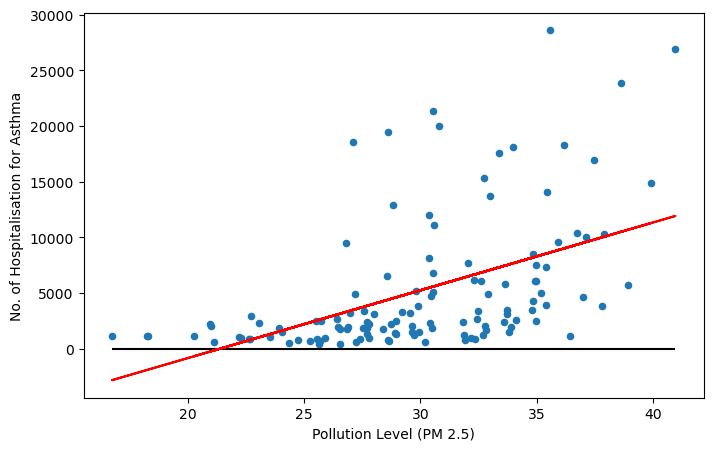

In [7]:
figure = plt.figure()
fig1 = airqual_hospital_df.plot.scatter('PM2.5','Hosp.', figsize=(8,5))
fig1.set_ylabel('No. of Hospitalisation for Asthma')

x_data = airqual_hospital_df['PM2.5']
y_data = airqual_hospital_df['Hosp.']

plt.hlines(0,min(x_data),max(x_data),colors='black')

[slope, intercept, rvalue, pvalue, stdeve] = stats.linregress(x_data,y_data)
y_reg = slope*x_data + intercept

plt.plot(x_data,y_reg,'r')
plt.xlabel('Pollution Level (PM 2.5)')

# Save figure as PNG to add to presentation
plt.savefig('Images/PM25_and_Hospitalisation_US.png')

# SHow
plt.show()

### Correlation

In [7]:
# Print the correlation coefficient bewteen PM2.5 and Number of hospitalisation
print(f"Correlation between PM2.5 density and hopsitalisation for asthma: {rvalue:.3f}")

Correlation between PM2.5 density and hopsitalisation for asthma: 0.493


We find a moderate correlation between the PM2.5 concentration and the number of hospitalisation. By looking at the scatter plot and the linear regression model, we can estimate that a linear model may not be the best fit and a square or exponential model may be more accurate. Nonetheless, the trend is clear that the higher the concentration of PM2.5 is, the more hospital admissions for asthma symptoms are observed.

# Gegraphical distribution

In [8]:
# Looking at the data for 2018 only
airqual_hospital_2018_df = airqual_hospital_df.loc[airqual_hospital_df['Year']==2018,:]

try:
    # Dependencies
    from api_keys import api_key_geoapify

    # Build the endpoint URL
    base_url = f"https://api.geoapify.com/v1/geocode/search?"

    params = {
        "apiKey":api_key_geoapify,
        "format":"json",
    }

    # Iterate through the types_df DataFrame
    for index, row in airqual_hospital_2018_df.iterrows():

        # Print current status
        print(f"Now adding longitude/latitude for: {airqual_hospital_2018_df.loc[index,'State']}...")

        # Add the state name as the search text
        params["text"] = airqual_hospital_2018_df.loc[index,'State']

        # Run request
        response = requests.get(base_url,params=params).json()

        airqual_hospital_2018_df.loc[index,'Lat'] = response['results'][0]['lat']
        airqual_hospital_2018_df.loc[index,'Lon'] = response['results'][0]['lon']
    
    display(airqual_hospital_2018_df)
except:
    print('Error: No API key found or Wrong API key.')
    print('Follow the steps below to solve:')
    print('1. Create a file called api_keys.py')
    print('2. In the file, include the line: api_key_geoapify = "..."')
    print('3. Replace ... with your geoapify API key')
    print('4. Restart Kernel and run this notebook again.')

Now adding longitude/latitude for: Arizona...
Now adding longitude/latitude for: California...
Now adding longitude/latitude for: Colorado...
Now adding longitude/latitude for: Connecticut...
Now adding longitude/latitude for: Florida...
Now adding longitude/latitude for: Kentucky...
Now adding longitude/latitude for: Maryland...
Now adding longitude/latitude for: Massachusetts...
Now adding longitude/latitude for: Michigan...
Now adding longitude/latitude for: Minnesota...
Now adding longitude/latitude for: New Jersey...
Now adding longitude/latitude for: New Mexico...
Now adding longitude/latitude for: New York...
Now adding longitude/latitude for: Oregon...
Now adding longitude/latitude for: Pennsylvania...
Now adding longitude/latitude for: Rhode Island...
Now adding longitude/latitude for: Tennessee...
Now adding longitude/latitude for: Utah...
Now adding longitude/latitude for: Washington...
Now adding longitude/latitude for: Wisconsin...


,State,Year,PM2.5,Hosp.,Lat,Lon
3,Arizona,2018,27.994505,3161,34.395342,-111.763275
10,California,2018,37.455983,16975,36.701463,-118.755997
15,Colorado,2018,27.782857,2236,38.725178,-105.607716
21,Connecticut,2018,28.950549,2451,41.650020,-72.734216
28,Florida,2018,32.992350,13711,28.542111,-81.379030
35,Kentucky,2018,27.519337,1856,37.572603,-85.155141
41,Maryland,2018,33.718906,3156,39.516240,-76.938207
45,Massachusetts,2018,35.162088,5015,42.378877,-72.032366
50,Michigan,2018,34.946593,6062,43.621195,-84.682435
55,Minnesota,2018,33.813187,1548,45.989659,-94.611329


In [9]:
try:
    # Configure the map
    map_plot_1 = airqual_hospital_2018_df.hvplot.points(
        'Lon',
        'Lat',
        geo=True,
        tiles = "OSM",
        frame_width = 800,
        frame_height = 600,
        size = "Hosp.",
        scale = 0.5,
        color = "PM2.5",
        cmap='bkr'
    )

    # Display the map
    display(map_plot_1)
except:
    print('Please run the block above first and make sure your API key is valid.')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (PM2.5,Hosp.)

# Answer to key questions
## Does a country’s air quality have an impact on the hospital admission due to asthma?
Yes. Although the data available do not allow to draw any conclusion for causality, there is a correlation between the concentration of PM2.5 in the air and the number of hospital admissions due to asthma. The higher concentration of PM2.5 is expected to cause asthmatic reactions and the data confirm that this could be the case.